In [1]:
import sys
sys.path.append('../..')
from TO.utils import check_package_status
check_package_status()

from experiments.utils import set_plt_template
set_plt_template()

<div class="alert alert-block alert-success" style="font-size: 14px; border-radius: 10px"><h4>[GO] TO @ 6a07678b6d3d1a38c08a707dd69fad4991fe3759
</h4><pre>  ✅ No changes found in the ./TO packge.</pre></div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

from tqdm import trange
from IPython.utils.io import capture_output

from TO import Topology, run_experiment
from TO.models import BinaryElasticMembraneModel
from TO.parameterizations import Capsules
from TO.utils import get_fitness_values, get_best_config, get_config

# 0329 Discrete vs Continuous

**goal** Investigating the effect of calculating geometrical properties (constraints) from the mesh in comparison to from the underlying geometry directly.

The volume and the diconnectedness constraints are both caluclated with *Topology.geometry*. When setting *Topology.continuous* to false, the geometry is calculated from the mesh itself. You can see some examples below, the discretized geometry will have these typical rasterized ragged edges, or whatever they are called.

Obviously using geometry calculated from the mesh will affect the value of the area for example compared to the underlying geometry version.

However, decoupling these calculations from an underlying continuous representation should mean a discretized parameterization, like a cell-based one, should be able to use the same distance calculations. We use a Capsule parameterization (centerpoints representation) to investigate how much quality of convergence is affected by calculating the constraints directly from the mesh opposed to the underlying continuous representation.

## Experiment

In [3]:
topology = Topology(
    continuous=False, 
    domain=box(0, 0, 100, 50), 
    density=1.
)
parameterization = Capsules(
    topology, 
    symmetry_y=True, 
    n_components_x=3, 
    n_components_y=2, 
    n_samples=1000
)
model = BinaryElasticMembraneModel(
    topology, 
    thickness=1, 
    E11=25, 
    E22=1, 
    G12=0.5, 
    nu12=0.25, 
    Emin=1e-9
)

n_runs = 100
budget = 500

In [4]:
for seed in trange(n_runs):
    with capture_output():
        run_experiment(
            topology, parameterization, model,
            sigma0=0.25, budget=budget, seed=seed,
            name='discrete'
        )

100%|██████████| 100/100 [1:29:54<00:00, 53.95s/it]


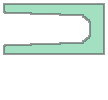

In [5]:
topology.geometry

Here in the geometry above you can see these discretized edges, topology.geometry is used by the constraints to calculate the relative area of the design and the disconnectedness.

In [6]:
topology.continuous = True

In [7]:
for seed in trange(n_runs):
    with capture_output():
        run_experiment(
            topology, parameterization, model,
            sigma0=0.25, budget=500, seed=seed,
            name='continuous'
        )

100%|██████████| 100/100 [1:28:08<00:00, 52.89s/it]


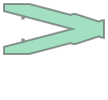

In [8]:
topology.geometry

See for this geometry the edges are much smoother since it's not discretized.

## Analysis

continuous
[029/100] converged before calling the simulation
[040/100] converged before calling the simulation
discrete
[001/100] converged before calling the simulation
[002/100] converged before exceeded budget @ 278 with fitness 0.22367718987119878
[003/100] converged before exceeded budget @ 86 with fitness 0.08668557417364661
[029/100] converged before calling the simulation
[040/100] converged before calling the simulation


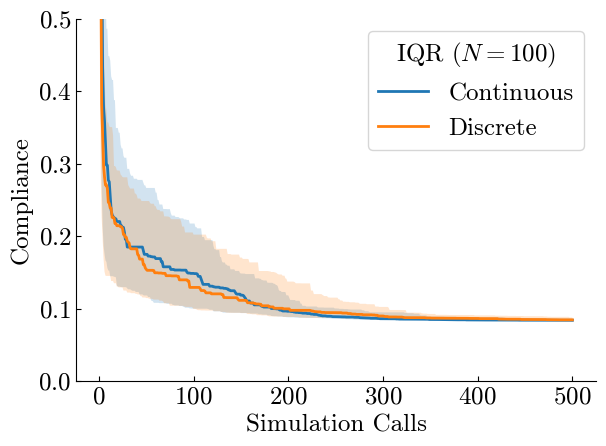

In [9]:
fig, ax = plt.subplots()

experiment_names = ('continuous', 'discrete')
experiments = {exp: None for exp in experiment_names}
for exp in experiment_names:
    print(exp)
    X = np.empty((n_runs, budget))
    for i in range(n_runs) :
        try:
            x = get_fitness_values(exp, i)
            X[i,:x.size] = np.minimum.accumulate(x)
            if (x.size < budget) :
                print(f'[{i+1:03d}/{n_runs:03d}] converged before exceeded budget @ {x.size} with fitness {x.min()}')
                X[i,x.size:] = x.min()
        except FileNotFoundError:
            print(f'[{i+1:03d}/{n_runs:03d}] converged before calling the simulation')
            X[i, :] = np.nan 
    experiments[exp] = X.copy()
    X = X[~np.isnan(X).any(axis=1)]

    (Q2) = np.median(X, axis=0)
    (Q1, Q3) = np.percentile(X, [25, 75], axis=0)

    ax.plot(np.arange(budget)+1, Q2, lw=2, label=exp.capitalize())
    ax.fill_between(np.arange(budget)+1, Q1, Q3, alpha=.2)
ax.set_ylim(0, 0.5)

ax.legend(title='IQR ($N=100$)');ax.set_xlabel('Simulation Calls'); ax.set_ylabel('Compliance'); fig.tight_layout()

The convergence curves are very similar, however it seems the IQR of the continuous case converges a bit faster than the discrete one. 

Nevertheless, it's quite close which also means that calculating the constraints directly from the mesh does not affect performance too much.

Still we have to note that the mesh is quite dense (100x50=5000 elements). Maybe I'll do an experiment with mesh-density 0.5, it should be quite quick. 

continuous
[071/100] best is 8.92% lower than the median
discrete
[086/100] best is 8.04% lower than the median


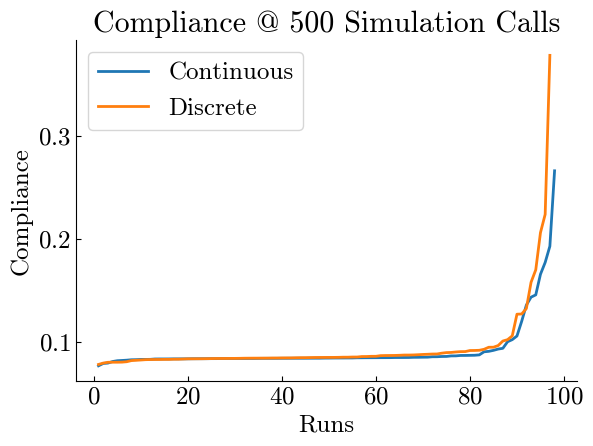

In [10]:
fig, ax = plt.subplots()
for exp in experiment_names :
    print(exp)
    f = experiments[exp][:,-1]
    diff = (np.nanmedian(f) - np.nanmin(f)) / np.nanmedian(f)
    print(f'[{np.nanargmin(f)+1:03d}/{n_runs:03d}] best is {diff*100:.2f}% lower than the median')

    ax.plot(np.arange(n_runs)+1, np.sort(f), lw=2, label=exp.capitalize())
ax.set_xlabel('Runs'); ax.set_ylabel('Compliance'); ax.set_title('Compliance @ 500 Simulation Calls'); ax.legend()
fig.tight_layout()

Quite nice distribution, only the last 10% is a bit poor.

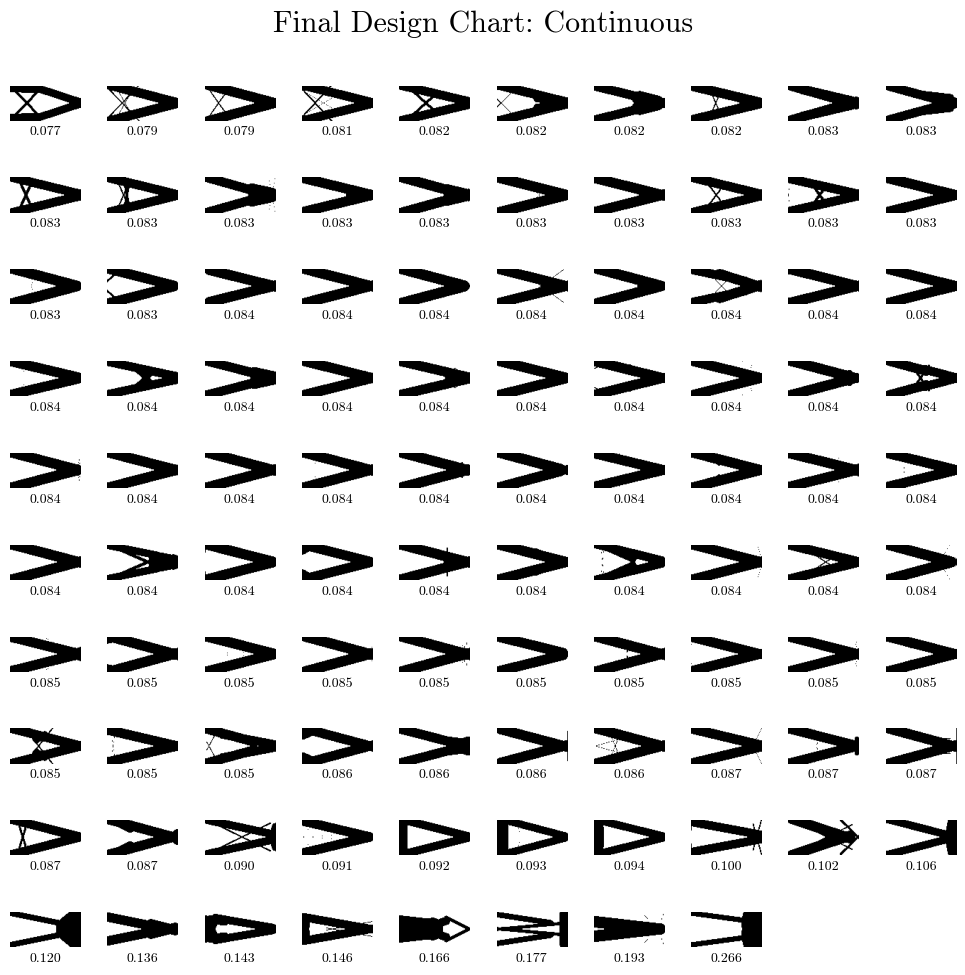

In [ ]:
exp = 'continuous'
idx = experiments[exp][:,-1].argsort().reshape(-1, 10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,10))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        if np.isnan(experiments[exp][idx[i,j]]).any() : continue
        parameterization.update_topology(topology, get_best_config(exp, idx[i,j]))
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{get_fitness_values(exp.lower(), idx[i,j]).min():.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

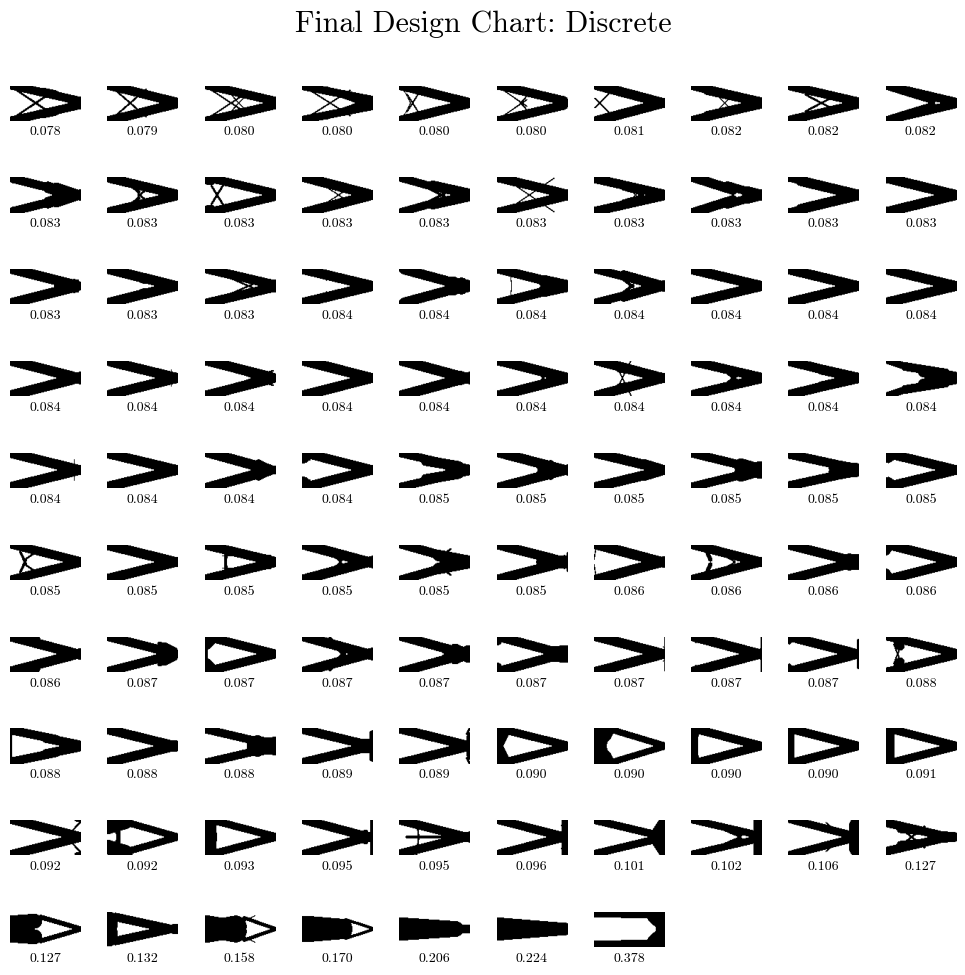

In [12]:
exp = 'discrete'
idx = experiments[exp][:,-1].argsort().reshape(-1, 10)

fig, ax = plt.subplots(*idx.shape, figsize=(10,10))

for i in range(len(idx)):
    for j in range(len(idx[0])) :
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].spines[:].set_visible(False)
        if np.isnan(experiments[exp][idx[i,j]]).any() : continue
        parameterization.update_topology(topology, get_best_config(exp.lower(), idx[i,j]))
        ax[i,j].imshow(topology.mask, cmap='binary')
        ax[i,j].set_xlabel(f'{get_fitness_values(exp.lower(), idx[i,j]).min():.3f}', fontsize=10)
fig.suptitle(f'Final Design Chart: {exp.capitalize()}')
fig.tight_layout()

Let's sample random designs and check the difference between the continuous and discrete representation of the geometry.

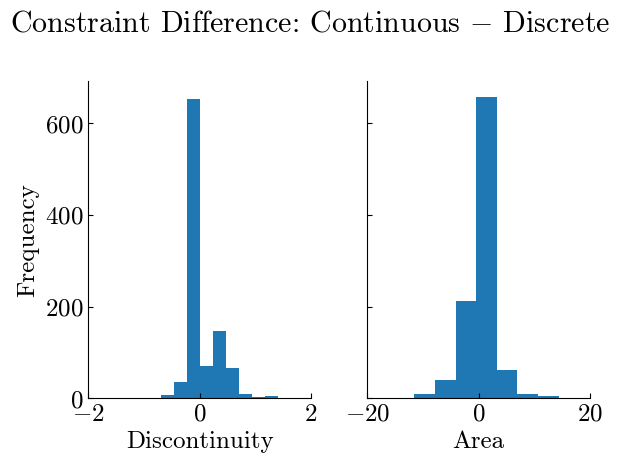

In [13]:
from TO import ProblemInstance

problem = ProblemInstance(topology, parameterization, None, budget=-1)

N = 1000
diff_disc = np.zeros(N, dtype=float)
diff_area = np.zeros(N, dtype=float)
for i in range(N):
    np.random.seed(i)
    x = np.random.rand(parameterization.dimension)

    topology.continuous = True
    d_continuous = problem.disconnection(x.copy())
    A_continuous = topology.geometry.area
    problem.x[:] = 0
    topology.continuous = False
    diff_disc[i] = d_continuous - problem.disconnection(x)
    diff_area[i] = A_continuous - topology.geometry.area

fig, ax = plt.subplots(1, 2, sharey=True)

ax[0].hist(diff_disc[np.abs(diff_disc) < 10])
ax[1].hist(diff_area)
ax[0].set_xlim(-2, 2);ax[1].set_xlim(-20, 20); ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Discontinuity'); ax[1].set_xlabel('Area')
fig.suptitle('Constraint Difference: Continuous $-$ Discrete'); fig.tight_layout()

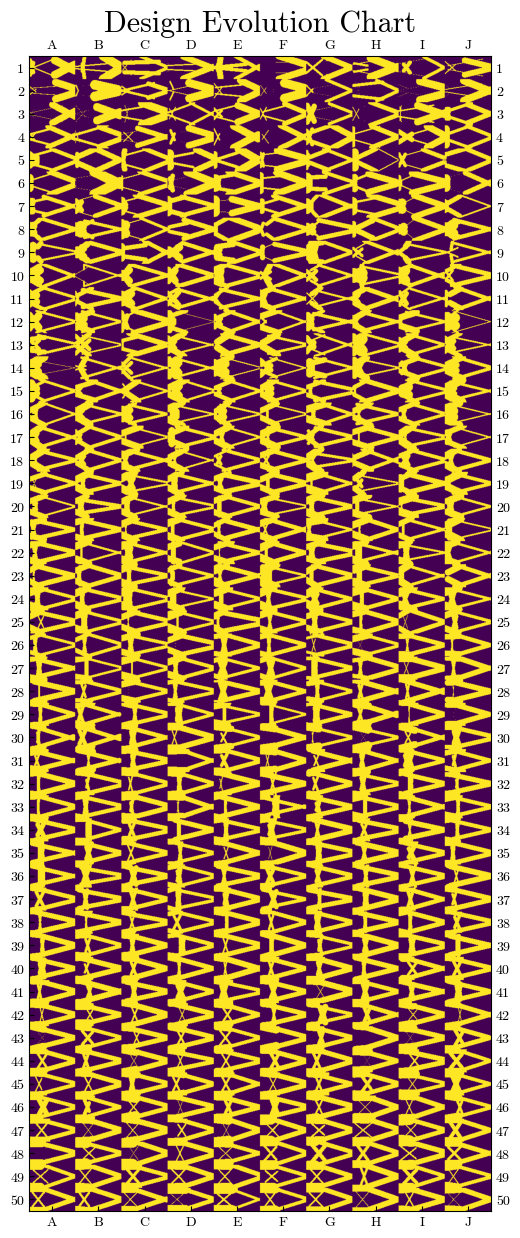

In [14]:
exp = 'continuous'
idx = np.nanargmin(experiments[exp][:,-1])

parameterization.update_topology(topology, np.zeros(parameterization.dimension))
im = np.zeros((50, 10, *topology.mask.shape))

evaluation = -2
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        parameterization.update_topology(topology, get_config(evaluation := evaluation+1, 'continuous', idx))
        im[i,j] = topology.mask
        
# thanks to GPT for the swapaxes, not very intuitive but whatever, maybe change reshape order or something?
im = im.swapaxes(1,2).reshape(im.shape[0]*topology.mask.shape[0], im.shape[1]*topology.mask.shape[1])


abc = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(im, extent=(0, 20, 50.5, 0.5))
ax.set_xticks([2*j + 1 for j in range(10)], [abc[j] for j in range(10)], fontsize=10)
ax.set_yticks([j+1 for j in range(50)], [j+1 for j in range(50)], fontsize=10);
ax.tick_params(labeltop=True, labelright=True)
ax.set_title('Design Evolution Chart')
ax.spines[:].set_visible(True)

In [15]:
import pickle
with open('convergence-curves.pkl', 'wb') as handle : pickle.dump(experiments, handle)